In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nazmul0087_ct_kidney_dataset_normal_cyst_tumor_and_stone_path = kagglehub.dataset_download('nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone')

print('Data source import complete.')


100%|██████████| 1.52G/1.52G [00:18<00:00, 86.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(nazmul0087_ct_kidney_dataset_normal_cyst_tumor_and_stone_path + '/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 12446 files [00:10, 1166.65 files/s]


In [ ]:
import torch
import torchvision
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import time
import torch
import numpy
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import zipfile
from pathlib import Path
import requests
from sklearn.model_selection import train_test_split

In [ ]:
def computeAccu(model,dataLoader,device):
  model.eval()
  with torch.no_grad():
    correctPred = 0
    totalPred = 0

    for features,targets in dataLoader:
      features = features.to(device)
      targets  = targets.to(device)

      logits   = model(features)
      _ , predLabel = torch.max(logits,1)
      totalPred += targets.size(0)
      correctPred += (predLabel == targets).sum()

  return correctPred.float()/totalPred * 100
def setAllSeeds(seed):
  os.environ['MY_GLOBAL_SEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [ ]:
def getEffNetModel(seed,numClasses):
  setAllSeeds(seed)
  effNetWeights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effNetTransforms = effNetWeights.transforms()
  effNet = torchvision.models.efficientnet_b2(weights=effNetWeights)
  for param in effNet.parameters():
    param.requires_grad = False
  effNet.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(1408,numClasses,bias=True)
  )
  return effNet,effNetTransforms

In [ ]:
model, transformers = getEffNetModel(42,4)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 40.2MB/s]


In [ ]:
trainDir = '/content/output/train'
testDir  = '/content/output/test'
valDir   = '/content/output/val'
batchSize = 32
randomSeed = 42
numEpochs = 8
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
trainData = datasets.ImageFolder(trainDir, transform=transformers)
testData = datasets.ImageFolder(testDir, transform=transformers)
classNames = trainData.classes
trainDataloader = DataLoader(
  trainData,
  batch_size=batchSize,
  shuffle=True,
  num_workers=0,
  pin_memory=True,
)
classNames = trainData.classes
testDataloader = DataLoader(
  testData,
  batch_size=batchSize,
  shuffle=False, # don't need to shuffle test data
  num_workers=0,
  pin_memory=True,
)
valData = datasets.ImageFolder(valDir, transform=transformers)
valDataloader = DataLoader(
  valData,
  batch_size=batchSize,
  shuffle=False, # don't need to shuffle test data
  num_workers=0,
  pin_memory=True,
)

In [ ]:
for images, labels in trainDataloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 288, 288])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([3, 1, 0, 1, 1, 1, 1, 0, 3, 1])


In [ ]:
def modelTrainer(model1, numEpochs, trainLoader,testLoader,valLoader, opt, device,scheduler=None,schedulerOn='validAcc'):
  startTime = time.time()
  miniBatchLoss = []
  trainAccLoss = []
  valAccLoss = []
  valPlotAccLoss =[]
  for e in range(numEpochs):
    model1.train()
    for batchIdx, (features,targets) in enumerate(trainLoader):
      features = features.to(device)
      targets  = targets.to(device)

      logits = model1(features)
      # _, predLabel = torch.max(logits,1)

      cost = torch.nn.functional.cross_entropy(logits,targets)
      opt.zero_grad()
      cost.backward()
      opt.step()
      miniBatchLoss.append(cost.item())
      if ( not (batchIdx%50) ):
        print('Epoch:%03d/%03d | Batch:%03d/%03d |  Cost:%.4f' %(e+1, numEpochs, batchIdx, len(trainLoader), cost.item()))
    with torch.no_grad():
      print('Epoch:%03d/%03d |' %(e+1, numEpochs))
      trainLoss = computeAccu(model1, trainLoader,device)
      valLoss   = computeAccu(model1, valLoader  ,device)
      valAccLoss.append(valLoss)
      trainAccLoss.append(trainLoss.cpu().numpy())

      print(f'Train Acc {trainLoss :.4f}%')
      print(f'Val Acc   {valLoss:.4f}%')
      print(f'Time Taken: {((time.time()-startTime)/60):.2f} min')
      if(scheduler is not None):
        if(schedulerOn == 'validAcc'):
          scheduler.step(valAccLoss[-1])
        elif(schedulerOn == 'miniBatchLoss'):
          scheduler.step(miniBatchLoss[-1])
        else:
          raise ValueError(f'invalid choice for SchedulerOn {schedulerOn}')
      # valAccLoss[-1] = valLoss.detach().numpy()
      valPlotAccLoss.append(valLoss.cpu().numpy())
#     break
    if(not((e+1)%3)):
        torch.save(model1.state_dict(), f'model{e+1}.pt')
        torch.save(opt.state_dict(), f'optimizer{e+1}.pt')
        torch.save(scheduler.state_dict(), f'schd{e+1}.pt')
  testLoss = computeAccu(model1, testLoader, device)
  print(f'Test Acc   {testLoss:.4f}%')
  print(f'Total Time Taken: {((time.time()-startTime)/60):.2f} min')

  return miniBatchLoss, trainAccLoss, valPlotAccLoss

In [ ]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9,lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
setAllSeeds(42)
miniBatchLossList, trainAccList, validAccList = modelTrainer(
    model1=model,
    numEpochs=numEpochs,
    trainLoader=trainDataloader,
    valLoader=valDataloader,
    testLoader=testDataloader,
    opt=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    schedulerOn='validAcc')

Epoch:001/008 | Batch:000/312 |  Cost:1.4015
Epoch:001/008 | Batch:050/312 |  Cost:0.9308
Epoch:001/008 | Batch:100/312 |  Cost:0.9199
Epoch:001/008 | Batch:150/312 |  Cost:1.1368
Epoch:001/008 | Batch:200/312 |  Cost:1.2050
Epoch:001/008 | Batch:250/312 |  Cost:0.6803
Epoch:001/008 | Batch:300/312 |  Cost:0.6130
Epoch:001/008 |
Train Acc 93.7418%
Val Acc   93.6393%
Time Taken: 4.59 min
Epoch:002/008 | Batch:000/312 |  Cost:0.3784
Epoch:002/008 | Batch:050/312 |  Cost:0.1837
Epoch:002/008 | Batch:100/312 |  Cost:0.4205
Epoch:002/008 | Batch:150/312 |  Cost:0.2677
Epoch:002/008 | Batch:200/312 |  Cost:0.7997
Epoch:002/008 | Batch:250/312 |  Cost:0.4924
Epoch:002/008 | Batch:300/312 |  Cost:1.1990
Epoch:002/008 |
Train Acc 96.1226%
Val Acc   95.0886%
Time Taken: 9.14 min
Epoch:003/008 | Batch:000/312 |  Cost:0.1684
Epoch:003/008 | Batch:050/312 |  Cost:0.1226
Epoch:003/008 | Batch:100/312 |  Cost:0.3467
Epoch:003/008 | Batch:150/312 |  Cost:0.6354
Epoch:003/008 | Batch:200/312 |  Cost:0.

In [ ]:
def plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100):
  plt.figure()
  ax1 = plt.subplot(1,1,1)
  ax1.plot(range(len(miniBatchLoss)), miniBatchLoss, label='Mini Batch Loss')
  if len(miniBatchLoss) > 1000:
    ax1.set_ylim([0,np.max(miniBatchLoss[1000:])*1.5])
  ax1.set_xlabel('Iterations')
  ax1.set_ylabel('Loss')
  ax1.plot(np.convolve(miniBatchLoss,np.ones(avgIter,)/avgIter,mode='valid'),label='Running Avg')
  ax1.legend()

  ax2 = ax1.twiny()
  newLabel = list(range(numEpoch+1))
  newPos = [e*iterPerEpoch for e in newLabel]
  # ax2.set_xticks(newpos[::10])
  # ax2.set_xticklabels(newlabel[::10])

  ax2.set_xticks(newPos[::10])
  ax2.set_xticklabels(newLabel[::10])
  ax2.spines['bottom'].set_position(('outward',45))
  ax2.set_xlabel("Epochs")
  ax2.set_xlim(ax1.get_xlim())

  plt.tight_layout()

  if(resultsDir is not None):
    imagePath = os.path.join(resultsDir, 'plotTrainingLoss.pdf')
    plt.savefig(imagePath)

def plotAccuracy(trainAccList, valAccList, resultsDir = None):
  numEpoch = len(trainAccList)
  plt.plot(np.arange(1,numEpoch+1),trainAccList,label='Training')
  plt.plot(np.arange(1,numEpoch+1),valAccList,label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()


  if(resultsDir is not None):
    imagePath = os.path.join(resultsDir, 'plotAccTrainingValidation.pdf')
    plt.savefig(imagePath)

def show_examples(model, dataLoader):
  for batchIdx, (features, targets) in enumerate(dataLoader):
    with torch.no_grad():
      features = features.to(torch.device('cpu'))
      targets  = targets.to(torch.device('cpu'))
      logits = model(features)
      predictions = torch.argmax(logits,dim=1)
    break

  fig, axes = plt.subplots(nrows=3,ncols=5,sharex=True,sharey=True)
  nhwcImage = np.transpose(features,axes = (0,2,3,1))
  nhwImage  = np.squeeze(nhwcImage.numpy(), axis=3)

  for idx,ax in enumerate(axes.ravel()):
    ax.imshow(nhwImage[idx],cmap='binary')
    ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
    ax.axison = False

  plt.tight_layout()
  plt.show()

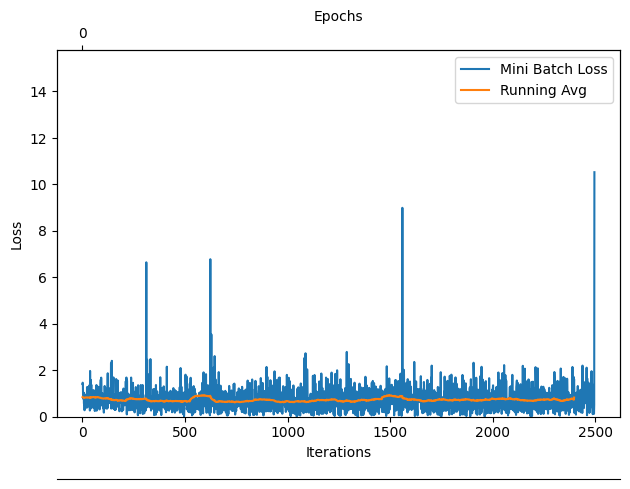

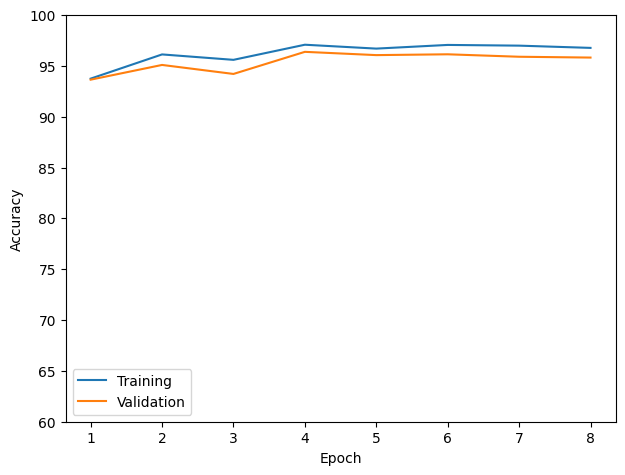

In [ ]:
plotTrainingLoss(miniBatchLoss=miniBatchLossList,
                   numEpoch=numEpochs,
                   iterPerEpoch=len(trainDataloader),
                   resultsDir=None,
                   avgIter=100)    #plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100)
plt.show()
plotAccuracy(trainAccList,validAccList)
plt.ylim([60,100])
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pt')
torch.save(optimizer.state_dict(), 'optimizer.pt')
torch.save(scheduler.state_dict(), 'scheduler.pt')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to display images with predictions in a grid layout
def display_predictions(model, dataloader, device, class_names, num_images=15):
    model.eval()  # Set model to evaluation mode
    images_shown = 0
    rows = 3  # Number of rows in the grid
    cols = num_images // rows  # Number of columns based on the total images and rows

    plt.figure(figsize=(15, 10))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)

            # Display sample images with actual vs predicted labels
            for i in range(len(images)):
                if images_shown == num_images:
                    break

                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)  # Scale image values if needed

                ax = plt.subplot(rows, cols, images_shown + 1)
                ax.imshow(img)
                ax.axis('off')
                actual_label = class_names[labels[i].item()]
                predicted_label = class_names[predicted_labels[i].item()]
                ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}', fontsize=10)

                images_shown += 1

            if images_shown == num_images:
                break
    plt.tight_layout()
    plt.show()

# Example usage
# Replace `testDataloader` with your test DataLoader, `model` with your trained model, and `classNames` with your class names list
display_predictions(model, testDataloader, DEVICE, classNames)
